# 0 Imports

In [12]:
import pickle
import datetime
import inflection

import numpy    as np
import pandas   as pd
import seaborn  as sns

from matplotlib import pyplot as plt

from IPython.display        import Image
from IPython.core.display   import HTML

## 0.1 Funções Suporte

In [7]:
# Supressão da notação científica.
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.6f}'.format)

In [26]:
def estatistica_descritiva(df1):
    # Medidas de tendência central - Mean, Median
    media = pd.DataFrame(df1.apply(np.mean)).T
    mediana = pd.DataFrame(df1.apply(np.median)).T
    
    # Medidas de Dispersão - Std, min, max, range, skew, kurtosis
    desvio_padrao = pd.DataFrame(df1.apply(np.std)).T
    minimo = pd.DataFrame(df1.apply(np.min)).T
    maximo = pd.DataFrame(df1.apply(np.max)).T
    range = pd.DataFrame(df1.apply(lambda x : x.max() - x.min())).T
    assimetria = pd.DataFrame(df1.apply(lambda x : x.skew())).T
    curtosis = pd.DataFrame(df1.apply(lambda x : x.kurtosis())).T
    
    estatistica = pd.concat([minimo, maximo, range, media, mediana, desvio_padrao, assimetria, curtosis]).T.reset_index()
    estatistica.columns = ['variaveis','minimo', 'maximo', 'range', 'media', 'mediana', 'desvio_padrao', 'assimetria', 'curtosis']
    
    return estatistica

In [44]:
def visualizacao_dados_categoricos(df):
    for i in df:
        print(f'Atributo: {i} - {df[i].sort_values().unique().tolist()}\n')

In [ ]:
## Function to reduce the DF size
## It is necessary that after using this code, carefully check the output results for each column.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 10242
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 10242
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18,10]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width: 100% !important;} </style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

## 0.2 Load Data

In [ ]:
df = pd.read_csv("../data/raw/azure_usage_1ano.csv")
df.sample()

# 1.0 Descrição dos Dados

## 1.1 Rename Columns

In [ ]:
columns_old = df.columns

snakecase = lambda x : inflection.underscore(x)

columns_new = list(map(snakecase,columns_old))

df.columns = columns_new

## 1.2 Data Dimension

In [18]:
df.shape

(4728, 10)

## 1.3 Data Types

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4728 entries, 0 to 4727
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subscription_name  4728 non-null   object 
 1   subscription_guid  4728 non-null   object 
 2   date               4728 non-null   object 
 3   resource_guid      4728 non-null   object 
 4   service_name       4728 non-null   object 
 5   service_type       4728 non-null   object 
 6   service_region     4728 non-null   object 
 7   service_resource   4728 non-null   object 
 8   quantity           4728 non-null   float64
 9   cost               4728 non-null   float64
dtypes: float64(2), object(8)
memory usage: 369.5+ KB


In [42]:
df.isna().sum()

subscription_name    0
subscription_guid    0
date                 0
resource_guid        0
service_name         0
service_type         0
service_region       0
service_resource     0
quantity             0
cost                 0
dtype: int64

## 1.4 Change types

In [21]:
df['date'] = pd.to_datetime( df['date'] )

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4728 entries, 0 to 4727
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   subscription_name  4728 non-null   object        
 1   subscription_guid  4728 non-null   object        
 2   date               4728 non-null   datetime64[ns]
 3   resource_guid      4728 non-null   object        
 4   service_name       4728 non-null   object        
 5   service_type       4728 non-null   object        
 6   service_region     4728 non-null   object        
 7   service_resource   4728 non-null   object        
 8   quantity           4728 non-null   float64       
 9   cost               4728 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 369.5+ KB


## 1.5 Estatística Descritiva

In [33]:
variaveis_categoricas = df.select_dtypes( exclude = ['int64','float64','datetime64[ns]'])
variaveis_numericas = df.select_dtypes( include = ['int64','float64'])

### 1.5.1 Variáveis Numéricas

In [38]:
estatistica_numerica = estatistica_descritiva(variaveis_numericas)
estatistica_numerica

,variaveis,minimo,maximo,range,media,mediana,desvio_padrao,assimetria,curtosis
0,quantity,0.000000,252.000000,252.000000,7.022578,0.114466,15.777792,7.966446,109.052088
1,cost,0.000000,13.176000,13.176000,0.499057,0.096768,1.239533,4.161124,24.601527


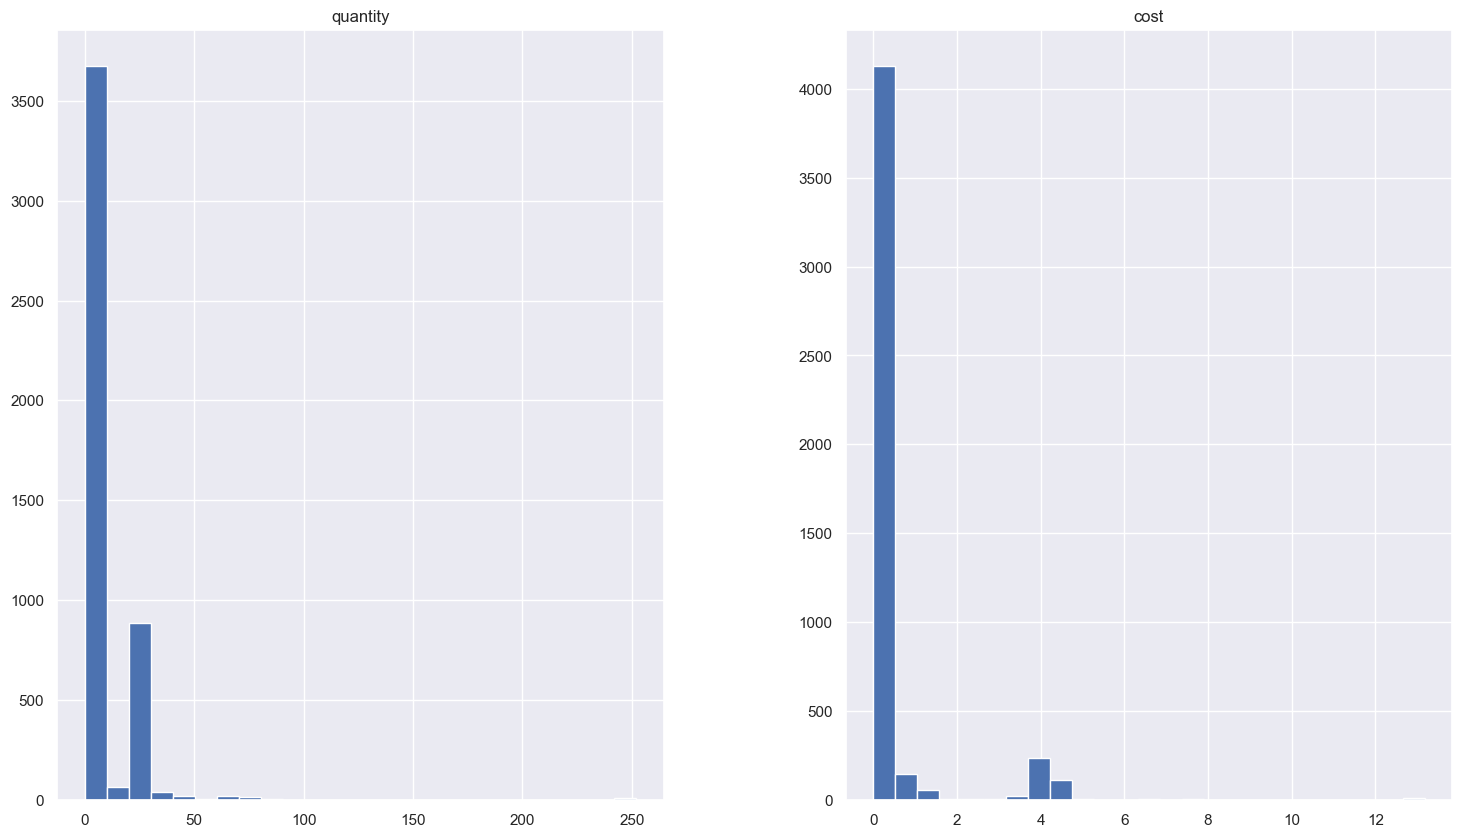

In [35]:
variaveis_numericas.hist(bins = 25);

### 1.5.2 Vairiáveis Categóricas

In [37]:
variaveis_categoricas.describe().T

,count,unique,top,freq
subscription_name,4728,1,Microsoft Azure Sponsorship,4728
subscription_guid,4728,1,82375e17-0dda-4790-b6e8-c565d4f08e87,4728
resource_guid,4728,53,cbe92596-7f61-5f48-ba3d-d624aa141eaf,367
service_name,4728,12,Storage,1958
service_type,4728,15,All,1308
service_region,4728,7,All,1767
service_resource,4728,46,GRS Data Stored,367


In [45]:
estatistica_categorica = visualizacao_dados_categoricos(variaveis_categoricas)
estatistica_categorica

Atributo: subscription_name - ['Microsoft Azure Sponsorship']

Atributo: subscription_guid - ['82375e17-0dda-4790-b6e8-c565d4f08e87']

Atributo: resource_guid - ['0b608a26-f611-4232-8192-ce81b6b57194', '0ddb5c81-143d-52f8-9ea3-29b64cc0ef97', '0f824807-2376-435c-95c9-f992b67a07b0', '0fcb37f3-8a5a-4e81-820e-848908a57e44', '11ecb7d4-b18a-447a-bb0c-f057585fc701', '12da282f-7e96-49e2-983a-9a65da2a4866', '17b3fc96-9141-4e25-88f2-b8953f3ca784', '1b74a37f-45a2-4266-bf07-2764801d0b85', '211e620c-ebcf-4db5-a7fd-996abebe9546', '26ce34b7-67b3-480d-9d1b-54a7fb80f67a', '28339581-90e9-4bde-93d2-a61b4f2a0b5e', '2dba9884-2518-4427-90ff-d2c100c5f775', '2f718765-8dfc-40cf-a636-b2d7d169d7d2', '334e1296-793b-4bd4-96ed-e82953411ce3', '3b2bbe89-0295-459e-b5e9-7e43b90318da', '3da19ca3-6007-4a29-89ea-cab10c2010ed', '3f2b1e1c-c886-4ec6-ad6f-dd0ef38819c9', '40551b4c-e8be-48ed-b70b-f8d25c7de724', '416a0a14-9d61-438f-a875-779e7b0e38c3', '42e2a22f-fabf-41ea-a21e-e86bb3ff5799', '43034668-a244-4031-bb4d-be5bcce22c5f'

# 1.6 Export PKL

In [43]:
pickle.dump(df,open("../data/interim/1_0_descricao_dados.pkl","wb"))